In [9]:
#!/usr/bin/env python
# encoding: utf-8

import os
import sys
import paramiko
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt


def _process_logs(logs):
    # loss_dict = OrderedDict()
    # lr_dict = OrderedDict()
    res = {"lm_loss": {}, "z_loss": {}, "aux_loss": {}, "lr": {}}
    # need_keys = {"lm loss:" : "lm_loss", "z_loss:" : "z_loss", "load_balancing_loss:" : "aux_loss", "learning rate:": "lr"}
    need_keys = {"lm loss:" : "lm_loss", "learning rate:": "lr"}
    for num, log in enumerate(logs):
        # log_split = log.split('|')
        # if len(log_split) != LOG_LEN:
        #     continue
        log_split = log.split('] iteration')
        if len(log_split) != 2:
            continue
        iteration = int(log_split[1].split("/")[0].strip())
        for k,v in need_keys.items():
            extract_value = float(log_split[1].split(k)[1].split("|")[0].strip())
            res[v][iteration] = extract_value
    return res


def _load_local_file(base_dir, file):
    with open(os.path.join(base_dir, file), "r") as f:
        logs = f.readlines()
    res = _process_logs(logs)
    return res


def stat(cuda_info, musa_info):
    cuda, cuda_lr = cuda_info["lm_loss"], cuda_info["lr"]
    musa, musa_lr = musa_info["lm_loss"], musa_info["lr"]
    c_ks = len(cuda.keys())
    m_ks = len(musa.keys())
    ks = cuda.keys() if c_ks < m_ks else musa.keys()
    x_axis, c_axis, m_axis, diff_ratios = [], [], [], []
    c_lr, m_lr = [], []

    # ==== stat ====
    for i, k in enumerate(ks):
        if STEPS > 9000 and i >= STEPS:
            break
        x_axis.append(int(k) - 1) # iter
        c_loss = cuda[k]
        m_loss = musa[k]
        diff_ratio = abs(m_loss - c_loss) / c_loss * 100
        c_axis.append(c_loss)
        m_axis.append(m_loss)
        diff_ratios.append(diff_ratio)
        c_lr.append(cuda_lr[k])
        m_lr.append(musa_lr[k])

    # ==== plotting ====
    plt.figure(figsize=(10, 8))
    # loss
    plt.subplot(2, 1, 1)
    plt.plot(x_axis, c_axis, color='green', linestyle='-.')
    plt.plot(x_axis, m_axis, color='orange', linestyle='-.')
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))
    plt.title("loss compare")
    plt.ylabel("loss")
    plt.legend(["cuda", "musa"], loc='upper right')
    # lr
    plt.subplot(2, 1, 2)
    plt.plot(x_axis, c_lr, color='green', linestyle='-.')
    plt.plot(x_axis, m_lr, color='orange', linestyle='-.')
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))
    plt.title("lr compare")
    plt.xlabel("iterations")
    plt.ylabel("lr")
    plt.legend(["cuda", "musa"], loc='upper right')

    plt.show()
    print(f"diff: {np.mean(diff_ratios):.3f}(+-{np.var(diff_ratios):.3f})%")
    return diff_ratios


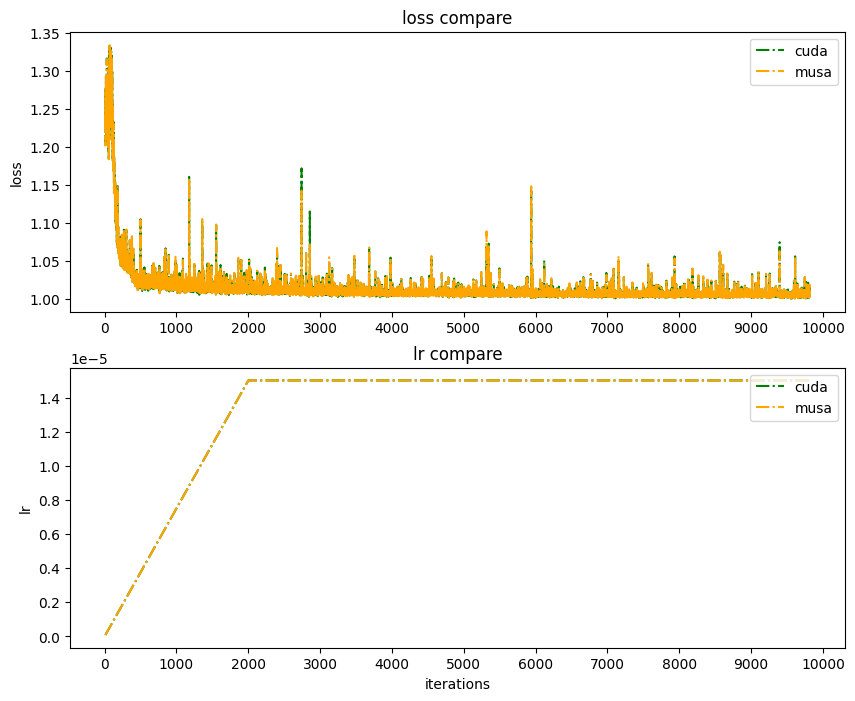

diff: 0.059(+-0.005)%


In [7]:
BASE_DIR_CUDA = "/data2/yutian.rong/projects/megatron-lm-musa-patch/examples/mixtral/output/compare_cuda"
BASE_DIR_MUSA = "/data2/yutian.rong/projects/megatron-lm-musa-patch/examples/mixtral/output/compare_musa"
STEPS = int(os.getenv("STEPS", 5000))

# ======== Mixtral ==========
# LOG_LEN = 14
# CUDA_FILE = "2024-05-17_04:00:23/tp1_pp1_dp4_mbs1_numbs1_gbs4_gpus4.log.0.172.31.208.8"
# CUDA_FILE = "2024-05-23_03:37:40/tp1_pp1_dp2_mbs1_numbs1_gbs2_gpus2.log.0.172.31.208.6" # 10b, 3 layers
CUDA_FILE = "tp2_pp1_dp4_mbs2_numbs2_gbs16_gpus8.log.0.172.31.208.6" # 10b, 6 layers
# MUSA_FILE = "2024-05-21_16:45:41/tp1_pp1_dp4_mbs1_numbs1_gbs4_gpus4.log.0.10.70.147.165"  # done
# MUSA_FILE = "2024-05-23_15:48:09/tp1_pp1_dp2_mbs1_numbs1_gbs2_gpus2.log.0.10.70.147.165"  # 10b, 3 layers
MUSA_FILE = "tp2_pp1_dp4_mbs2_numbs2_gbs16_gpus8.log.0.10.70.147.226" # 10b, 6 layers

cuda_info = _load_local_file(BASE_DIR_CUDA, CUDA_FILE)
# print(f"cuda iterations: {len(cuda_info[1])}")
musa_info = _load_local_file(BASE_DIR_MUSA, MUSA_FILE)
# print(f"musa iterations: {len(musa_info[1])}")
stat(cuda_info, musa_info)

In [ ]:
abs_diff = 1e-2
rel_diff = 5e-3

In [8]:
1e-2 / 3

0.0033333333333333335

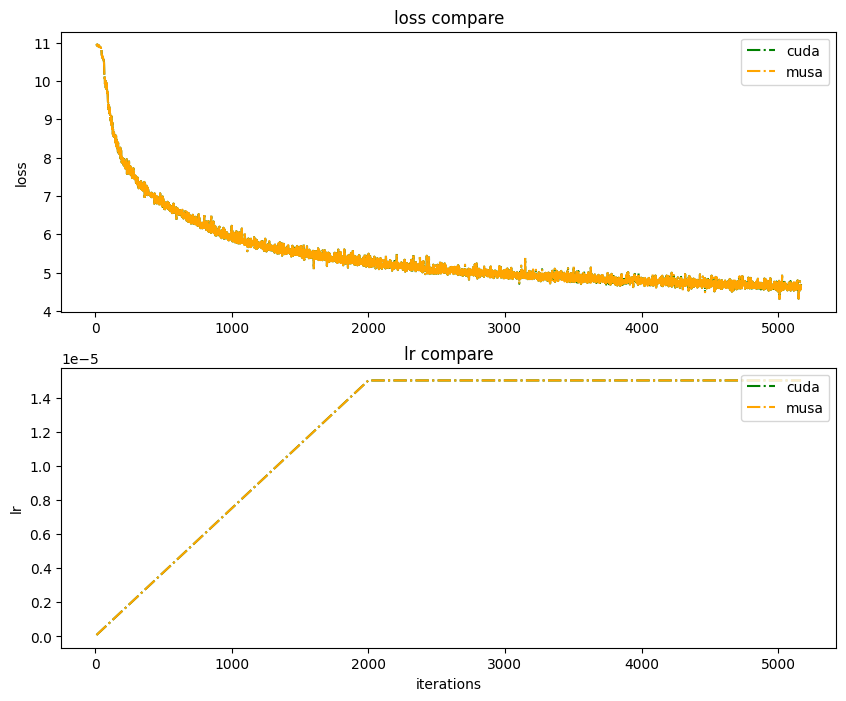

diff: 0.005(+-0.000)%


[0.0003659022967711139,
 0.0006394662101569402,
 0.0010055506395246156,
 0.0004571913455496397,
 0.0007311912476455559,
 0.0003659803010964375,
 0.00027378482884217556,
 0.0010042672227208007,
 0.0004571892553199317,
 0.0007323177306986137,
 0.0001830430727899993,
 0.0001828290603227957,
 0.0004581296946829786,
 0.00045774509274266643,
 0.0010071968795153402,
 0.0009175069501293069,
 0.00018318625003313697,
 0.0010059083397975597,
 0.00027525006467334485,
 0.0,
 0.0006418167448074855,
 9.180738443168405e-05,
 9.178522257568998e-05,
 0.0012835628771614648,
 0.0003677876835284635,
 0.000644367856714003,
 0.00018415137979327945,
 0.00018370550538779958,
 0.0006448350097591419,
 0.0002766070639971069,
 0.00027635378812545196,
 9.203171045901534e-05,
 0.0002757697653278743,
 0.0006456355498085014,
 0.0004617235771746347,
 0.0012937782205377033,
 0.0008298533280359079,
 0.0014874063166525195,
 9.345043295231806e-05,
 0.0004685974129663104,
 0.0010298381562635667,
 9.369621251445425e-05,
 0.0

In [10]:
BASE_DIR_CUDA = "/data2/yutian.rong/projects/megatron-lm-musa-patch/examples/llama2/output/compare_cuda"
BASE_DIR_MUSA = "/data2/yutian.rong/projects/megatron-lm-musa-patch/examples/llama2/output/compare_musa"
STEPS = 5000

# ======== Mixtral ==========
# LOG_LEN = 14
# CUDA_FILE = "2024-05-17_04:00:23/tp1_pp1_dp4_mbs1_numbs1_gbs4_gpus4.log.0.172.31.208.8"
# CUDA_FILE = "2024-05-23_03:37:40/tp1_pp1_dp2_mbs1_numbs1_gbs2_gpus2.log.0.172.31.208.6" # 10b, 3 layers
CUDA_FILE = "tp2_pp2_dp2_mbs2_numbs2_gbs8_gpus8.log.0." # 10b, 6 layers
# MUSA_FILE = "2024-05-21_16:45:41/tp1_pp1_dp4_mbs1_numbs1_gbs4_gpus4.log.0.10.70.147.165"  # done
# MUSA_FILE = "2024-05-23_15:48:09/tp1_pp1_dp2_mbs1_numbs1_gbs2_gpus2.log.0.10.70.147.165"  # 10b, 3 layers
MUSA_FILE = "tp2_pp2_dp2_mbs2_numbs2_gbs8_gpus8.log.0.10.70.147.226" # 10b, 6 layers

cuda_info = _load_local_file(BASE_DIR_CUDA, CUDA_FILE)
# print(f"cuda iterations: {len(cuda_info[1])}")
musa_info = _load_local_file(BASE_DIR_MUSA, MUSA_FILE)
# print(f"musa iterations: {len(musa_info[1])}")
stat(cuda_info, musa_info)